# Heart Failure Clinical Records Dataset - Lab 6

#### MinMax Normalization

In [105]:
import ds_functions as ds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, validation_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.metrics as metrics
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score


data: pd.DataFrame = pd.read_csv('datasets/heart_failure_clinical_records_dataset.csv')
original_data = data.copy()
target = 'DEATH_EVENT'

transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(data)
df_nr = pd.DataFrame(transf.transform(data), columns= data.columns)
norm_data_minmax = df_nr


### Balancing

In [106]:
data_unbalanced = original_data.copy()
target_count = original_data[target].value_counts()
min_class = target_count.idxmin()
ind_min_class = target_count.index.get_loc(min_class)

RANDOM_STATE = 42
values = {'Original': [target_count.values[ind_min_class], target_count.values[1-ind_min_class]]}

df_class_min = original_data[original_data[target] == min_class]
df_class_max = original_data[original_data[target] != min_class]

df_under = df_class_max.sample(len(df_class_min))
values['UnderSample'] = [target_count.values[ind_min_class], len(df_under)]
df_over = df_class_min.sample(len(df_class_max), replace=True)
values['OverSample'] = [len(df_over), target_count.values[1-ind_min_class]]
smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
y = original_data.pop(target).values
X = original_data.values
smote_X, smote_y = smote.fit_sample(X, y)
smote_target_count = pd.Series(smote_y).value_counts()
values['SMOTE'] = [smote_target_count.values[ind_min_class], smote_target_count.values[1-ind_min_class]]

over_sampled = pd.concat([df_over, df_class_max])
under_sampled = pd.concat([df_under, df_class_min])

#### Unbalanced Classification

In [89]:
y: np.ndarray = data_unbalanced.pop(target).values
X: np.ndarray = data_unbalanced.values
labels = pd.unique(y)

#### Over Sampled Classification

In [90]:
y: np.ndarray = over_sampled.pop(target).values
X: np.ndarray = over_sampled.values
labels: np.ndarray = pd.unique(y)

#### Under Sampled Classification

In [107]:
y: np.ndarray = under_sampled.pop(target).values
X: np.ndarray = under_sampled.values
labels: np.ndarray = pd.unique(y)

## Gradient Boosting

In [3]:
def gradient_boosting(X, y):
    print('{', len(X), ',', len(y), '}')
    trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

    n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
    max_depths = [5, 10, 25]
    learning_rate = [.1, .3, .5, .7, .9]
    best = ('', 0, 0)
    last_best = 0
    best_tree = None

    cols = len(max_depths)
    plt.figure()
    fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
    for k in range(len(max_depths)):
        d = max_depths[k]
        values = {}
        for lr in learning_rate:
            yvalues = []
            for n in n_estimators:
                gb = GradientBoostingClassifier(n_estimators=n, max_depth=d, learning_rate=lr)
                gb.fit(trnX, trnY)
                prdY = gb.predict(tstX)
                yvalues.append(metrics.accuracy_score(tstY, prdY))
                if yvalues[-1] > last_best:
                    best = (d, lr, n)
                    last_best = yvalues[-1]
                    best_tree = gb
            values[lr] = yvalues
        ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Gradient Boorsting with max_depth=%d'%d,
                            xlabel='nr estimators', ylabel='accuracy', percentage=True)

    plt.show()
    print('Best results with depth=%d, learning rate=%1.2f and %d estimators, with accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

    prd_trn = best_tree.predict(trnX)
    prd_tst = best_tree.predict(tstX)
    ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)


#### Unbalanced Classification

{ 299 , 299 }


<Figure size 600x450 with 0 Axes>

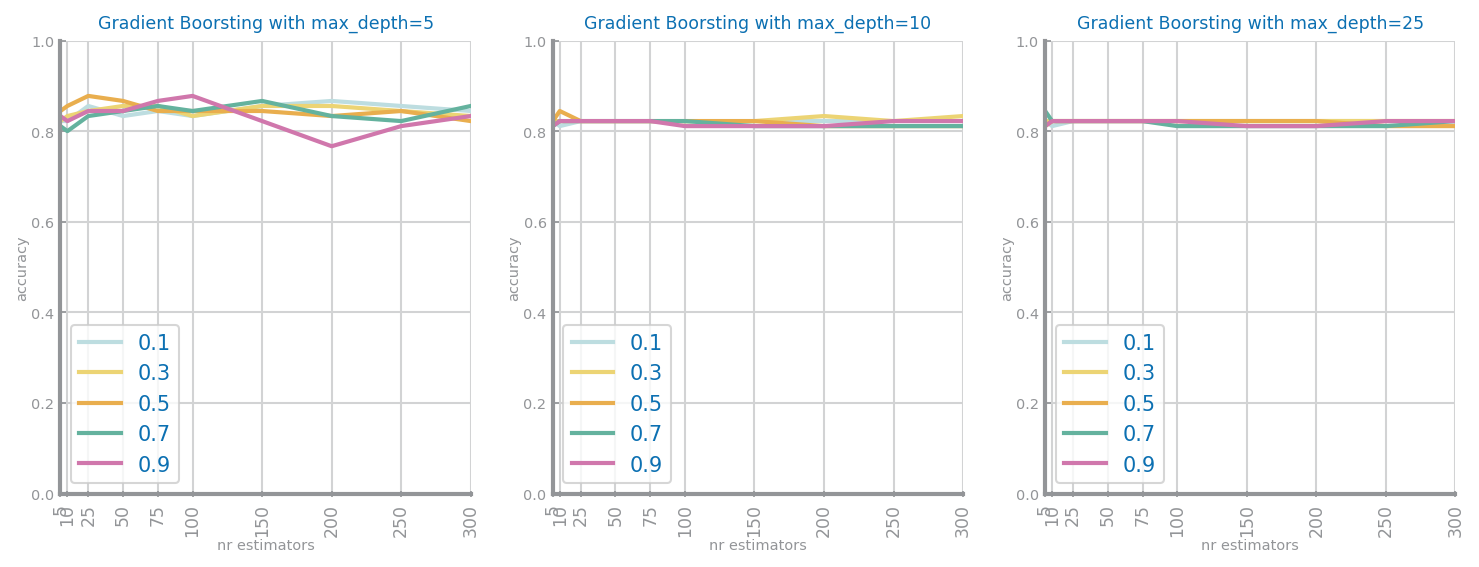

Best results with depth=5, learning rate=0.50 and 25 estimators, with accuracy=0.88
Confusion Matrix Test
TruePositives:  21
FalsePositives:  3
TrueNegatives:  58
FalseNegatives:  8


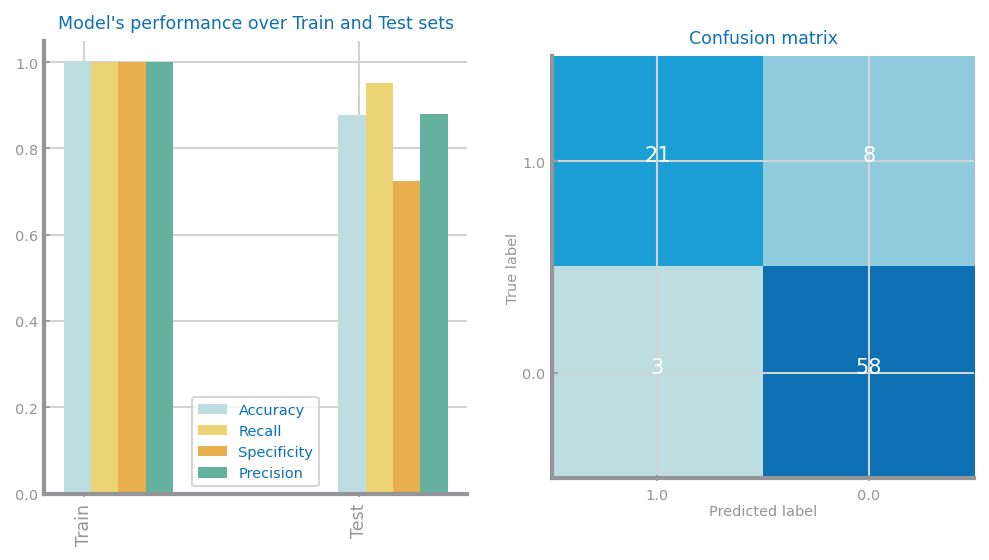

In [4]:
y: np.ndarray = norm_data_minmax.pop(target).values
X: np.ndarray = norm_data_minmax.values
labels = pd.unique(y)
gradient_boosting(X, y)

#### Over Sampled Classification

{ 406 , 406 }


<Figure size 600x450 with 0 Axes>

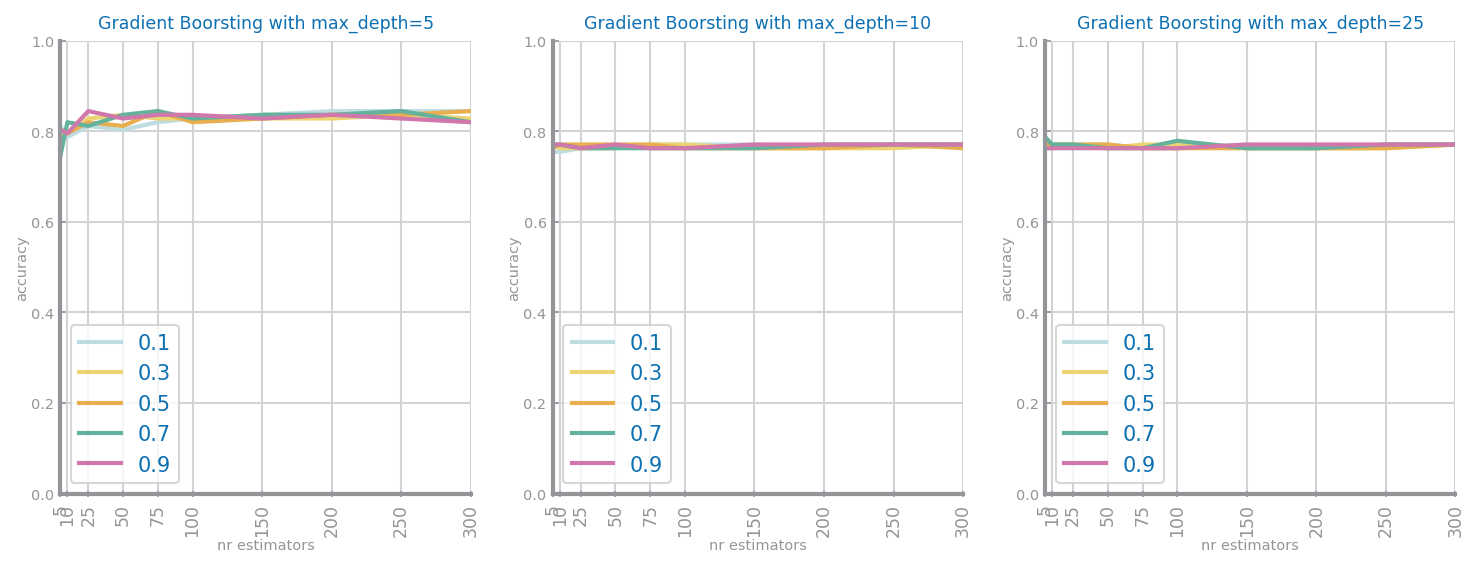

Best results with depth=5, learning rate=0.10 and 200 estimators, with accuracy=0.84
Confusion Matrix Test
TruePositives:  47
FalsePositives:  5
TrueNegatives:  56
FalseNegatives:  14


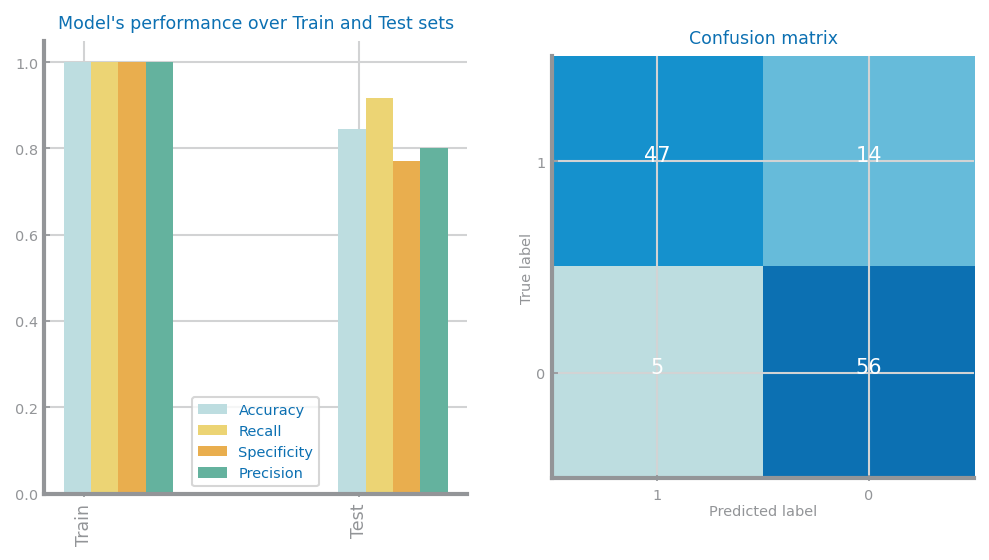

In [5]:
y: np.ndarray = over_sampled.pop(target).values
X: np.ndarray = over_sampled.values
labels: np.ndarray = pd.unique(y)
gradient_boosting(X, y)


#### Under Sampled Classification

{ 192 , 192 }


<Figure size 600x450 with 0 Axes>

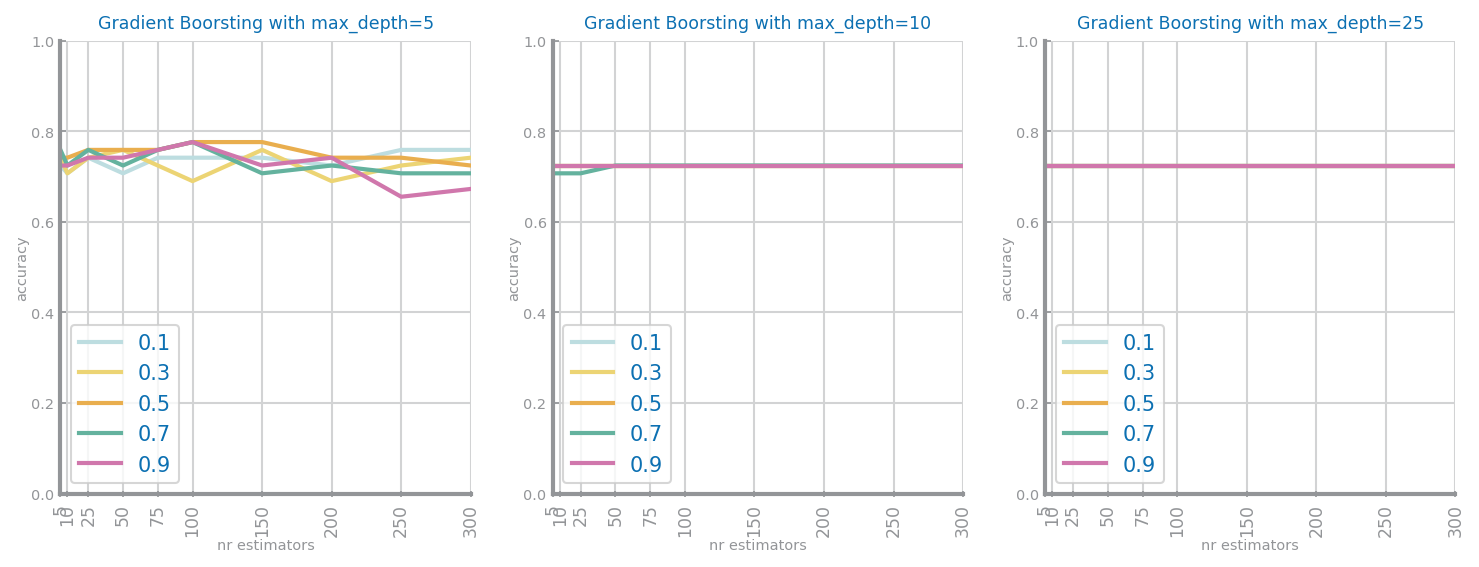

Best results with depth=5, learning rate=0.50 and 100 estimators, with accuracy=0.78
Confusion Matrix Test
TruePositives:  22
FalsePositives:  6
TrueNegatives:  23
FalseNegatives:  7


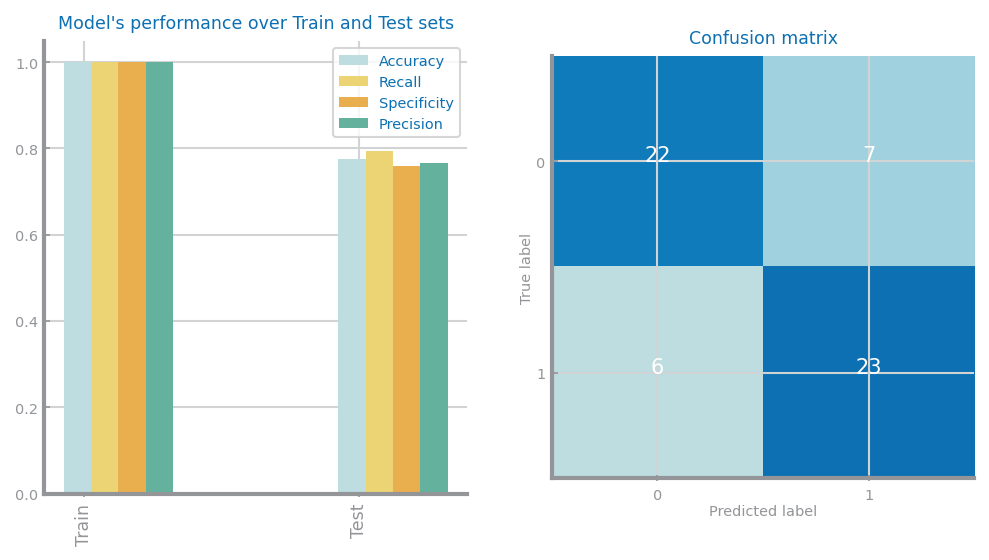

In [12]:
y: np.ndarray = under_sampled.pop(target).values
X: np.ndarray = under_sampled.values
labels: np.ndarray = pd.unique(y)
gradient_boosting(X, y)

#### SMOTE classification

{ 406 , 406 }


<Figure size 600x450 with 0 Axes>

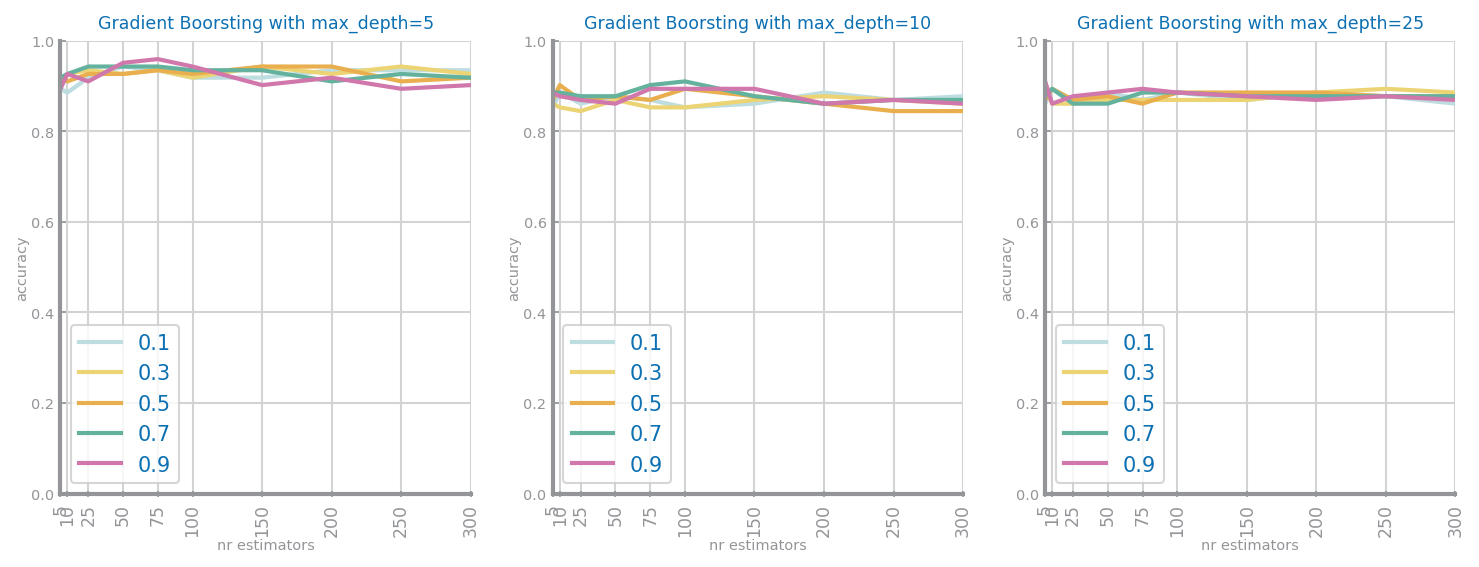

Best results with depth=5, learning rate=0.90 and 75 estimators, with accuracy=0.96
Confusion Matrix Test
TruePositives:  59
FalsePositives:  3
TrueNegatives:  58
FalseNegatives:  2


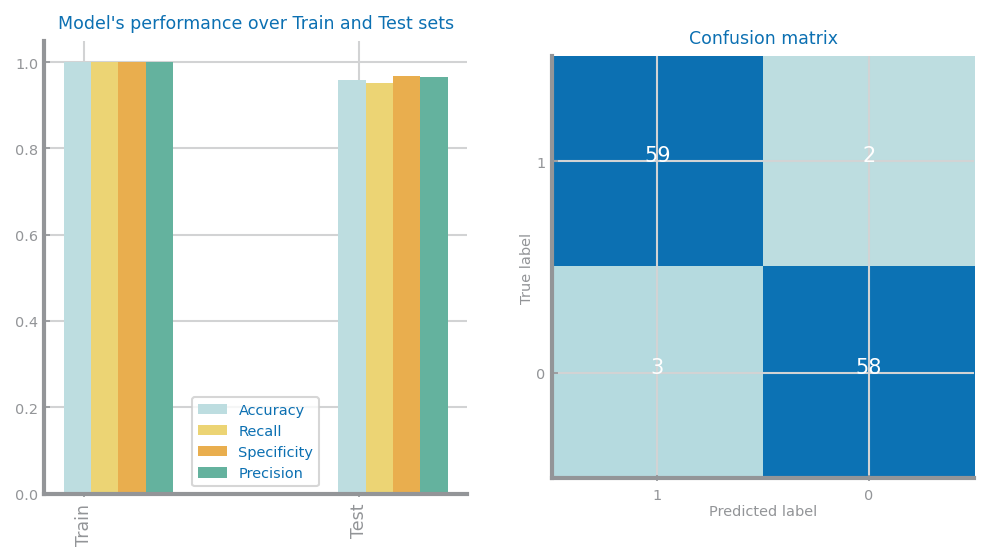

In [7]:
y = smote_y
X = smote_X
labels = pd.unique(y)
gradient_boosting(X, y)

<h1 style="color:blue">Logistic Regression </h1>

In [111]:
precison_list = []
recall_list = []
f1_list = []
mcc_list = []

def logistic_regression_kfold(X,y,num_splits_kfold, stratified=True):

    labels = pd.unique(y)
    
    
    
    if stratified:
        cv = StratifiedKFold(n_splits=num_splits_kfold, random_state=50,shuffle=False)
        cv_split = cv.split(X, y)
    else:
        cv = KFold(n_splits=num_splits_kfold, random_state=50,shuffle=False)
        cv_split = cv.split(X)
        

    for train_index, test_index in cv_split:
        trnX, tstX = X[train_index], X[test_index]
        trnY, tstY = y[train_index], y[test_index]
        
        clf = LogisticRegression(random_state=0 , solver ='lbfgs', max_iter = 1250)
        model = clf.fit(trnX, trnY)

        # print(model.intercept_)
        # print(model.coef_)
        # model.score(X_train, y_train)

        predictions = model.predict(tstX)
        precison = round(precision_score(tstY,predictions),3)
        recall = round(recall_score(tstY,predictions),3)
        f1 = round(f1_score(tstY,predictions),3)
        mcc = round(matthews_corrcoef(tstY,predictions),3)
        
        precison_list.append(precison)
        recall_list.append(recall)
        f1_list.append(f1)
        mcc_list.append(mcc)
        
        print(f'\nPrecision: {precison}')
        print(f'\nRecall: {recall}')
        print(f'\nF1 Score: {f1}')
        print(f'\nMCC: {mcc}\n')
        
        
    print(len(precison_list))

    folds = range(1,6)
    
    plt.plot(folds, precison_list, label='Precision')
    plt.plot(folds, recall_list, label='Recall')
    plt.plot(folds, f1_list, label='F1 Score')
    plt.plot(folds, mcc_list, label='MCC')
    plt.legend()
    plt.title('Rate Vs Folds')
    plt.xlabel('Folds')
    plt.ylabel('Rate')
    plt.show()

In [112]:
def Average(lst): 
    return sum(lst) / len(lst)

def plot_metrics():
    max_array = [max(precison_list),max(recall_list),max(f1_list),max(mcc_list)]
    mean_array = [Average(precison_list),Average(recall_list),Average(f1_list),Average(mcc_list)]
    append_list = mean_array + max_array

    print(max_array)
    print(mean_array)

    #create toy dataframe
    df = pd.DataFrame({"Legend": ["Precision","Recall","F1 Score","MCC","Precision","Recall","F1 Score","MCC"], "clm2": np.asarray(append_list), "Max/Mean": ["Mean", "Mean", "Mean", "Mean", "Max", "Max", "Max", "Max"]})
    #rearrange dataframe and plot
    df.pivot(index = "Max/Mean", columns = "Legend", values = "clm2").plot.bar(edgecolor = "white")
    plt.xticks(rotation = 0)
    plt.show()
    

**F1 Score**: Por vezes pode ser dificil comparar 2 modelos com baixa precision e elevado recall, ou vice versa. Por outras palavras, se um modelo tem elevada precisão respetivamente a um outro modelo mas baixo recall como é que podemos determinar qual o melhor modelo? Nestes casos F1 score ajuda a medir o recall e a precision ao mesmo tempo. Utiliza a média harmónica em vez da média aritmética.

**MCC: Matthews Correlation Coeficient (MCC)** é uma métrica compreendida entre -1 e 1 em que -1 indica uma completa falha de classificação binária por parte do nosso modelo, enquanto que 1 indica uma perfeita classificação e 0 não indica que o nosso modelo não é melhor que uma metodologia de divisão random. Esta métrica permite verificar o quão bem o nosso modelo está a classificar. Esta métrica tem em consideração todos os elementos da matriz de confusão.

## Unbalanced Classification


Precision: 0.429

Recall: 0.9

F1 Score: 0.581

MCC: 0.309


Precision: 0.708

Recall: 0.895

F1 Score: 0.791

MCC: 0.687


Precision: 1.0

Recall: 0.684

F1 Score: 0.813

MCC: 0.773


Precision: 1.0

Recall: 0.579

F1 Score: 0.733

MCC: 0.696


Precision: 0.0

Recall: 0.0

F1 Score: 0.0

MCC: 0.0

5


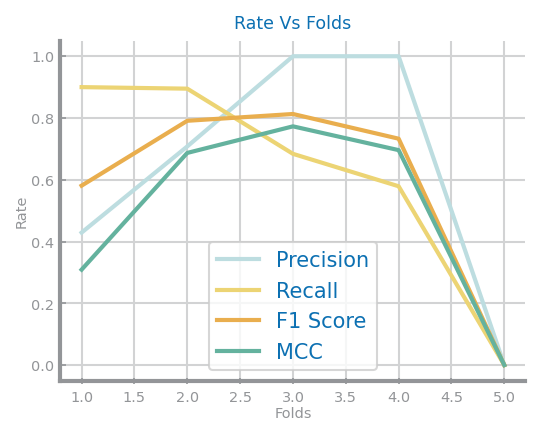

In [85]:
logistic_regression_kfold(X,y,num_splits_kfold=5, stratified=True)

[1.0, 0.9, 0.813, 0.773]
[0.6274, 0.6115999999999999, 0.5835999999999999, 0.493]


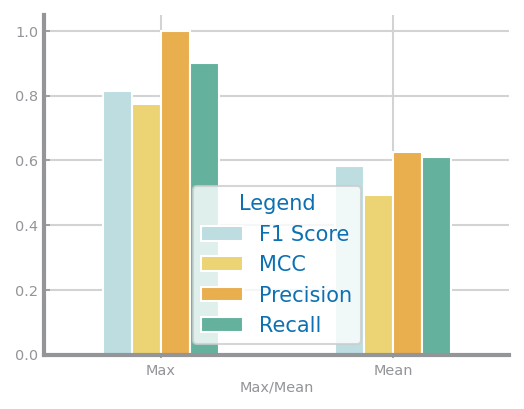

In [86]:
plot_metrics()

## Over Sampled Classification


Precision: 0.541

Recall: 0.805

F1 Score: 0.647

MCC: 0.14


Precision: 0.486

Recall: 0.829

F1 Score: 0.613

MCC: -0.103


Precision: 0.968

Recall: 0.732

F1 Score: 0.833

MCC: 0.727


Precision: 0.938

Recall: 0.75

F1 Score: 0.833

MCC: 0.717


Precision: 1.0

Recall: 0.775

F1 Score: 0.873

MCC: 0.797

5


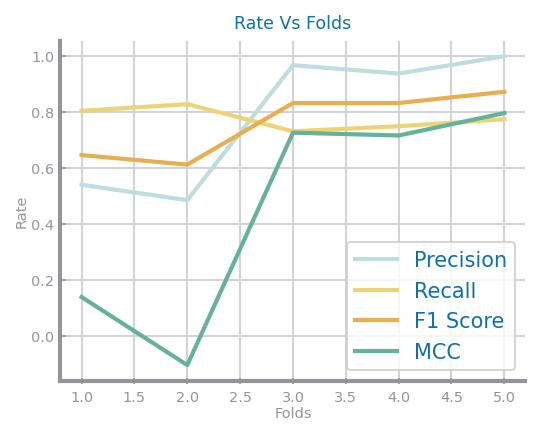

In [96]:
logistic_regression_kfold(X,y,num_splits_kfold=5, stratified=True)

[1.0, 0.829, 0.873, 0.797]
[0.7866, 0.7781999999999999, 0.7598, 0.4556]


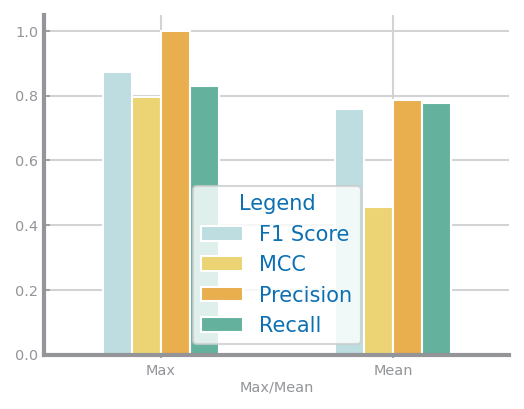

In [97]:
plot_metrics()

## Under Sampled Classification


Precision: 0.76

Recall: 1.0

F1 Score: 0.864

MCC: 0.729


Precision: 0.792

Recall: 0.95

F1 Score: 0.864

MCC: 0.706


Precision: 0.76

Recall: 1.0

F1 Score: 0.864

MCC: 0.721


Precision: 0.8

Recall: 0.842

F1 Score: 0.821

MCC: 0.632


Precision: 0.0

Recall: 0.0

F1 Score: 0.0

MCC: -0.343

5


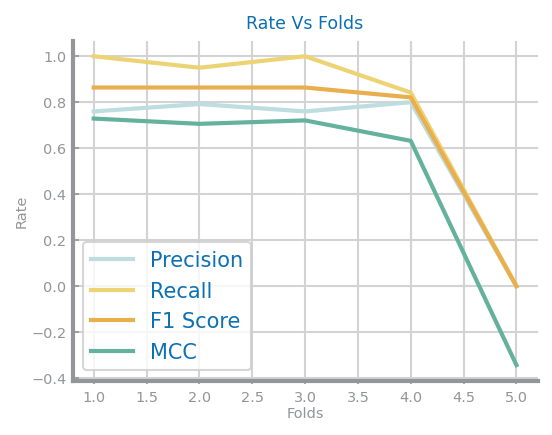

In [113]:
logistic_regression_kfold(X,y,num_splits_kfold=5, stratified=True)

[0.8, 1.0, 0.864, 0.729]
[0.6224000000000001, 0.7584000000000001, 0.6826000000000001, 0.48900000000000005]


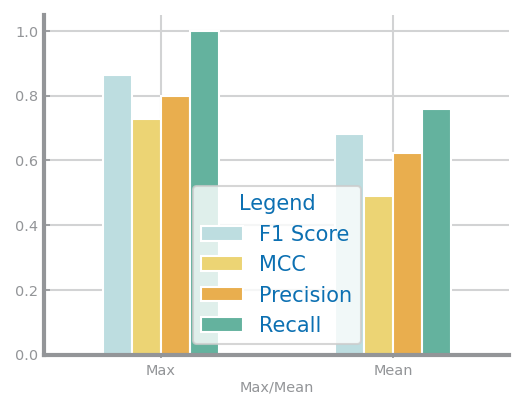

In [114]:
plot_metrics()